# 词包

在这个例子中，我们将下载和预处理 ham/spam 文本数据。我们然后使用一个独热编码来实现一个特征词包集合，并在逻辑回归中使用。

我将在逻辑回归中使用独热编码向量，并用来预测文本是spam还是ham。

首先加载库。

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
from tensorflow.python.framework import ops
ops.reset_default_graph()

/home/zhangxin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


开始一个计算图会话。

In [2]:
# 创建一个计算图会话
sess = tf.Session()

检查数据是否下载成功，否则下载数据并保存。

In [3]:
print(os.path.abspath('.'))

/home/zhangxin/zhangxin/projects/Tensorflow cookbook 代码部分中文翻译/tensorflow手册-by_zhangxin/07_自然语言处理/2 词包


In [4]:
save_file_name = os.path.join('temp','temp_spam_data.csv')

# 如果目录不存在则创建目录
if not os.path.exists('temp'):
    os.makedirs('temp')

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
#     zip_url = './temp/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # 格式化数据
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    # 并且写入到csv文件中
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

为了降低潜在的字典尺寸，我们归一化文本。为了做这些，我们移除文本中字母和数值的影响。

In [5]:
# 令spam为1,ham为0
target = [1 if x=='spam' else 0 for x in target]

# 归一化文本，字母小写
texts = [x.lower() for x in texts]

# 移除标点符号
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# 移除数字
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# 去除额外的空格
texts = [' '.join(x.split()) for x in texts]

为了得到合理的用于填充和裁剪的句子长度，我们画出文本长度的直方图。

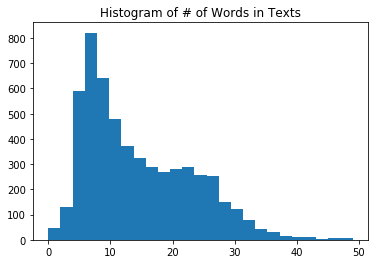

In [6]:
%matplotlib inline
# 打印文本长度的直方图
text_lengths = [len(x.split()) for x in texts]
# print(text_lengths)
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title('Histogram of # of Words in Texts')
plt.show()

我们裁剪和填充所有的文本为25个词语长度。我们也滤出掉没有出现过3次的句子。

In [7]:
# 选择长度为25的最大文本单词长度
sentence_size = 25
min_word_freq = 3

TensorFlow有一个内建的文本处理函数`VocabularyProcessor()`。我们使用这个函数处理文本。

In [8]:
# 建立字典处理器
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, 
                                                          min_frequency=min_word_freq)

# 使用句子长度设定转换文本。
vocab_processor.transform(texts)
embedding_size = len([x for x in vocab_processor.transform(texts)])

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


为了测试我们的逻辑模型（预测 spam/ham），我们将数据集划分为训练集和测试集。

In [9]:
# 将数据集分割为训练和测试集
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

对于独热编码，我们使用TensorFlow词嵌入来设置一个单位矩阵。

我们也创建变量和占位符来设计逻辑回归。

In [10]:
# 设置独热编码的索引矩阵
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

# 创建逻辑回归的变量
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# 初始化占位符
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1, 1], dtype=tf.float32)

下部，我们使用先验单位矩阵来建立文本-词嵌入。

我们的逻辑回归将使用像输入一样的词计数。这个计数主要是用来根据行来对嵌入式输出求和。

然后我们声明逻辑回归操作。注意我们不用在sigmoid函数包围逻辑操作，因为这将在后面的损失函数中实现。

In [11]:
# 文本-字典 嵌入
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_col_sums = tf.reduce_sum(x_embed, 0)

# 声明模型操作
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

现在我们声明我们的损失函数（内建sigmoid）、预测操作、优化器以及初始化变量。

In [12]:
# 声明损失函数（交叉熵损失）
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, 
                                                              labels=y_target))

# 预测操作
prediction = tf.sigmoid(model_output)

# 声明优化器
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

现在我们将迭代循环操作，并且使用逻辑回归算法来预测文本是spam还是ham。

In [ ]:
# 开始逻辑回归
print('Starting Training Over {} Sentences.'.format(len(texts_train)))
loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1)%10==0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))
        
    # 保持过去50个观测准确率的平均值
    # 得到单个观测的预测值
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # 如果预测是正确的，用True/False标记
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

Starting Training Over 4459 Sentences.
Training Observation #10: Loss = 36.278435
Training Observation #20: Loss = 1.8613873e-16
Training Observation #30: Loss = 1.24038875e-20
Training Observation #40: Loss = 9.9649615e-17
Training Observation #50: Loss = 3.4959235e-24
Training Observation #60: Loss = 8.112127e-24
Training Observation #70: Loss = 5.2291088e-20
Training Observation #80: Loss = 4.9888293e-10
Training Observation #90: Loss = 2.8326494e-18
Training Observation #100: Loss = 16.04187
Training Observation #110: Loss = 2.7905763e-24
Training Observation #120: Loss = 9.637382e-08
Training Observation #130: Loss = 2.5585064e-07
Training Observation #140: Loss = 3.925065e-21
Training Observation #150: Loss = 0.21577086
Training Observation #160: Loss = 0.0030319488
Training Observation #170: Loss = 7.972908e-16
Training Observation #180: Loss = 7.8645867e-23
Training Observation #190: Loss = 3.2819763e-23
Training Observation #200: Loss = 0.0035019922
Training Observation #210: 

Training Observation #1750: Loss = 4.064007e-09
Training Observation #1760: Loss = 0.11417313
Training Observation #1770: Loss = 4.5107052e-07
Training Observation #1780: Loss = 0.0036725125
Training Observation #1790: Loss = 1.2537584
Training Observation #1800: Loss = 1.0074664e-05
Training Observation #1810: Loss = 3.3423257
Training Observation #1820: Loss = 8.1260195
Training Observation #1830: Loss = 6.3774426e-09
Training Observation #1840: Loss = 0.0065294984
Training Observation #1850: Loss = 3.467237
Training Observation #1860: Loss = 5.180409
Training Observation #1870: Loss = 2.4035358e-09
Training Observation #1880: Loss = 1.9656987e-08
Training Observation #1890: Loss = 2.731517e-07
Training Observation #1900: Loss = 0.47368896
Training Observation #1910: Loss = 0.4943487
Training Observation #1920: Loss = 1.6062488e-08
Training Observation #1930: Loss = 1.7189963e-07
Training Observation #1940: Loss = 1.3569823e-08
Training Observation #1950: Loss = 4.125088e-08
Training

Training Observation #3490: Loss = 0.00016370442
Training Observation #3500: Loss = 0.00077553577
Training Observation #3510: Loss = 2.3859296
Training Observation #3520: Loss = 0.6624009
Training Observation #3530: Loss = 4.2383294
Training Observation #3540: Loss = 0.39205667
Training Observation #3550: Loss = 0.001716052
Training Observation #3560: Loss = 0.01411311
Training Observation #3570: Loss = 0.84152585
Training Observation #3580: Loss = 5.1727705
Training Observation #3590: Loss = 0.0050689797
Training Observation #3600: Loss = 0.008887734
Training Observation #3610: Loss = 5.827019
Training Observation #3620: Loss = 14.301231
Training Observation #3630: Loss = 0.00020039278
Training Observation #3640: Loss = 0.029396951
Training Observation #3650: Loss = 8.190143
Training Observation #3660: Loss = 0.5387722
Training Observation #3670: Loss = 2.8419497
Training Observation #3680: Loss = 6.600277
Training Observation #3690: Loss = 0.002655209
Training Observation #3700: Loss

现在我们已经训练好模型了，我们使用测试集来评估模型的准确性。

In [21]:
# 得到测试集准确性
print('Getting Test Set Accuracy For {} Sentences.'.format(len(texts_test)))
test_acc_all = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    
    if (ix+1)%50==0:
        print('Test Observation #' + str(ix+1))    
    
    # 保持过去50个观测准确率的平均值
    # 得到单个观测的预测值
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # 如果预测是正确的，用True/False标记
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)

print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))

Getting Test Set Accuracy For 1115 Sentences.
Test Observation #50
Test Observation #100
Test Observation #150
Test Observation #200
Test Observation #250
Test Observation #300
Test Observation #350
Test Observation #400
Test Observation #450
Test Observation #500
Test Observation #550
Test Observation #600
Test Observation #650
Test Observation #700
Test Observation #750
Test Observation #800
Test Observation #850
Test Observation #900
Test Observation #950
Test Observation #1000
Test Observation #1050
Test Observation #1100

Overall Test Accuracy: 0.7964125560538117


让我们看看在所有迭代运算上的训练准确率。

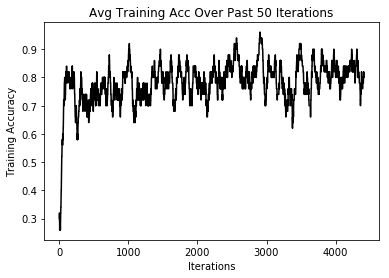

In [22]:
%matplotlib inline
# 打印训练准确率随时间的变化
plt.plot(range(len(train_acc_avg)), train_acc_avg, 'k-', label='Train Accuracy')
plt.title('Avg Training Acc Over Past 50 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.show()

限制句子的长度是非常有用的。在本例子中我们将文本长度限制为25个词。这是一个常见的关于词包的联系，因为它限制了文本长度在预测中的影响。你可以想想如果我们发现一个词，例如"meeting"，预测一个文本是ham或者是spam，然后在最后一个spam消息应该用词较多的次数来完成。实际上，对于不平衡目标数据这也是常见问题。在这种情况下不平衡数据也经常出现，因此spam很难检测出，而ham很容易检测出来。因为这个问题，我们创建的字典被我们数据中的ham部分严重弯曲了（更多的ham意味着比spam有更多的词）。如果允许无限制的文本长度，然后spammers也会利用这些并且创建非常长的文本，在我们逻辑模型中这些长文本将会触发得到非spam词的更高概率值。

在下节中，我们尝试将使用词出现的频次来解决上述问题，来得到更好的词嵌入。